In [1]:
import statsmodels
import statsmodels.tsa.stattools as sm_tstat
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
with open("n1.txt") as f:
    raw_data = []
    for line in f:
        raw_data.append(line)

splitted_data = []

for i in range(len(raw_data)):
    splitted_data.append(raw_data[i].split("\t"))

s1 = []
s2 = []

for i in range(1, len(splitted_data)):
    s1_split = splitted_data[i][0]
    s2_split = splitted_data[i][1][:-1]
    
    if s1_split != "":
        s1.append(float(s1_split))
    if s2_split != "":
        s2.append(float(s2_split))

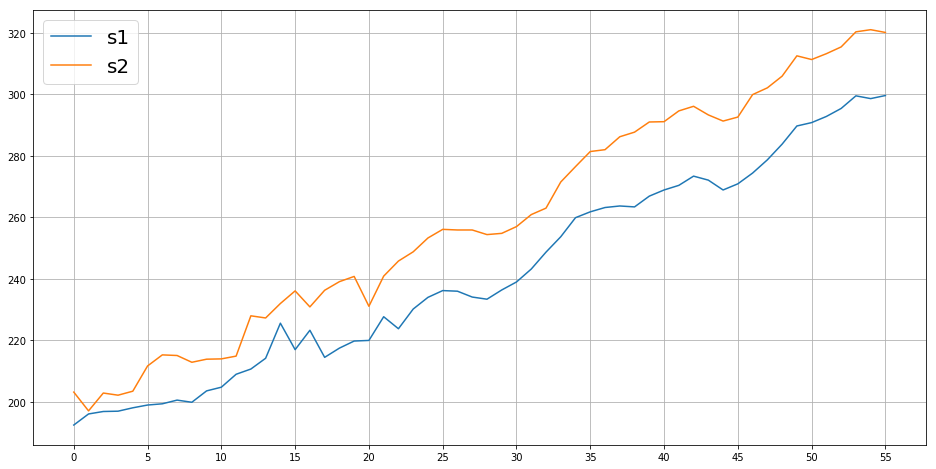

Длина ряда s1: 56
Длина ряда s2: 56


In [3]:
def show_graph(y1, y2, x_ticks=10):
    plt.figure(figsize=(16,8))
    plt.plot(y1, label="s1")
    plt.plot(y2, label="s2")
    plt.grid()
    plt.legend(loc='upper left', fontsize=20)
    plt.xticks(np.arange(0, len(y1), x_ticks))
    plt.show()

show_graph(s1, s2, 5)
print(f"Длина ряда s1: {len(s1)}")
print(f"Длина ряда s2: {len(s2)}")

# Тестирование рядов на единичный корень.

### По Дибову и Нерлову выберем максимальный лаг

In [4]:
p_max = len(s1) ** 0.25
p_max = round(p_max)

### Проведем тест Дики-Фуллера для первого ряда  с параметром regression='ct'

In [5]:
test1 = sm_tstat.adfuller(s1, maxlag=p_max, regression='ct', regresults=True)
test1[3].__dict__["resols"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     4.826
Date:                Wed, 12 Aug 2020   Prob (F-statistic):            0.00125
Time:                        17:04:22   Log-Likelihood:                -127.36
No. Observations:                  52   AIC:                             266.7
Df Residuals:                      46   BIC:                             278.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4447      0.117     -3.787      0.000      -0.681      -0.208
x2            -0.0076      0.139     -0.054      0.957      -0.288       0.273
x3             0.4518      0.142      3.192      0.003       0.167       0.737
x4             0.2080      0.143      1.451      0.154      -0.081       0.497
const         84.9060     22.029      3.854      0.000      40.564     129.248
x5             0.9062      0.237      3.823      0.000       0.429       1.383
==============================================================================
Omnibus:                        7.189   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               12.019
Skew:                           0.186   Prob(JB):                      0.00246
Kurtosis:                       5.326   Cond. No.                     1.32e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Для x5 значение в столбце P>|t| равно 0.000. Отвергаем предположение о нулевом  коэффициенте тренда. Тренд есть, возьмем разности, чтобы детрендировать ряд.

In [6]:
diff_s1 = np.array(pd.Series(s1).diff(periods=1).dropna())

test_diff_s1_ct = sm_tstat.adfuller(diff_s1, maxlag=p_max, regression='ct', regresults=True)
test_diff_s1_ct[3].__dict__["resols"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     24.73
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           6.88e-12
Time:                        17:04:22   Log-Likelihood:                -126.37
No. Observations:                  51   AIC:                             264.7
Df Residuals:                      45   BIC:                             276.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.4495      0.281     -5.156      0.000      -2.016      -0.883
x2             0.2316      0.247      0.936      0.354      -0.267       0.730
x3             0.5801      0.212      2.742      0.009       0.154       1.006
x4             0.4602      0.134      3.436      0.001       0.190       0.730
const          2.2261      0.944      2.358      0.023       0.324       4.128
x5             0.0244      0.030      0.810      0.422      -0.036       0.085
==============================================================================
Omnibus:                        7.626   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               12.341
Skew:                           0.280   Prob(JB):                      0.00209
Kurtosis:                       5.344   Cond. No.                         66.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Для x5 значение в столбце P>|t| равно 0.422. НЕ МОЖЕМ отвергнуть предположение о нулевом  коэффициенте тренда.

#### В ряде разностей тренда нет, проведем тест с параметром regression="c"

In [7]:
test_diff_s1_c = sm_tstat.adfuller(diff_s1, maxlag=p_max, regression='c', regresults=True)
test_diff_s1_c[3].__dict__["resols"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     30.98
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           1.58e-12
Time:                        17:04:22   Log-Likelihood:                -126.74
No. Observations:                  51   AIC:                             263.5
Df Residuals:                      46   BIC:                             273.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.3924      0.271     -5.136      0.000      -1.938      -0.847
x2             0.1846      0.240      0.770      0.445      -0.298       0.667
x3             0.5510      0.208      2.652      0.011       0.133       0.969
x4             0.4489      0.133      3.382      0.001       0.182       0.716
const          2.7486      0.687      4.003      0.000       1.367       4.131
==============================================================================
Omnibus:                        5.992   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                8.544
Skew:                           0.150   Prob(JB):                       0.0140
Kurtosis:                       4.982   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Для const в столбце P>|t| видим значение 0.000. Константа присутствует. Проверим результаты теста Дики-Фуллера.

In [8]:
print('Augmented Dickey-Fuller Test Results: ', test_diff_s1_c[0])
print('p-value: ', test_diff_s1_c[1])
print('Critical values: ', test_diff_s1_c[2])

Augmented Dickey-Fuller Test Results:  -5.136205096084015
p-value:  1.1849829507372394e-05
Critical values:  {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}


### Результат теста не превышает критических значений. p-value < 0.05. Можем сделать вывод, что ряд стационарен.

In [9]:
print('Augmented Dickey-Fuller Test Results: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[2])

Augmented Dickey-Fuller Test Results:  -3.786973814770361
p-value:  0.017231732152759537
Critical values:  {'1%': -4.1443354969845245, '5%': -3.498585183773327, '10%': -3.1783837960855714}


### Проведем тест Дики-Фуллера для второго ряда  с параметром regression='ct' (проверка значимости константы и тренда)

In [10]:
test2 = sm_tstat.adfuller(s2, maxlag=p_max, regression='ct', regresults=True)
test2[3].__dict__["resols"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     8.301
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           0.000744
Time:                        17:04:22   Log-Likelihood:                -144.02
No. Observations:                  55   AIC:                             294.0
Df Residuals:                      52   BIC:                             300.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4546      0.112     -4.060      0.000      -0.679      -0.230
const         90.0206     21.742      4.140      0.000      46.393     133.648
x2             1.0500      0.258      4.073      0.000       0.533       1.567
==============================================================================
Omnibus:                        5.276   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.440
Skew:                          -0.494   Prob(JB):                        0.109
Kurtosis:                       3.980   Cond. No.                     1.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Для x2 значение в столбце P>|t| равно 0.000. Отвергаем предположение о нулевом  коэффициенте тренда. Тренд есть, возьмем разности, чтобы детрендировать ряд.

In [11]:
diff_s2 = np.array(pd.Series(s2).diff(periods=1).dropna())

test_diff_s2_ct = sm_tstat.adfuller(diff_s2, maxlag=p_max, regression='ct', regresults=True)
test_diff_s2_ct[3].__dict__["resols"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     37.07
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           1.15e-10
Time:                        17:04:22   Log-Likelihood:                -146.31
No. Observations:                  54   AIC:                             298.6
Df Residuals:                      51   BIC:                             304.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1445      0.133     -8.580      0.000      -1.412      -0.877
const          2.7055      1.057      2.559      0.014       0.583       4.828
x2            -0.0041      0.033     -0.125      0.901      -0.070       0.062
==============================================================================
Omnibus:                        5.534   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                7.074
Skew:                          -0.201   Prob(JB):                       0.0291
Kurtosis:                       4.727   Cond. No.                         65.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Для x2 значение в столбце P>|t| равно 0.901. НЕ МОЖЕМ отвергнуть предположение о нулевом  коэффициенте тренда.

#### В ряде разностей тренда нет, проведем тест с параметром regression="c"

In [12]:
test_diff_s2_c = sm_tstat.adfuller(diff_s2, maxlag=p_max, regression='c', regresults=True)
test_diff_s2_c[3].__dict__["resols"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     75.56
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           1.04e-11
Time:                        17:04:22   Log-Likelihood:                -146.32
No. Observations:                  54   AIC:                             296.6
Df Residuals:                      52   BIC:                             300.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1457      0.132     -8.693      0.000      -1.410      -0.881
const          2.5956      0.580      4.472      0.000       1.431       3.760
==============================================================================
Omnibus:                        5.470   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                7.025
Skew:                          -0.184   Prob(JB):                       0.0298
Kurtosis:                       4.728   Cond. No.                         5.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Для const в столбце P>|t| видим значение 0.000. Константа присутствует. Проверим результаты теста Дики-Фуллера.

In [13]:
print('Augmented Dickey-Fuller Test Results: ', test_diff_s2_c[0])
print('p-value: ', test_diff_s2_c[1])
print('Critical values: ', test_diff_s2_c[2])

Augmented Dickey-Fuller Test Results:  -8.6925589756177
p-value:  4.004013303413477e-14
Critical values:  {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


### Результат теста не превышает критических значений. p-value < 0.05. Можем сделать вывод, что ряд стационарен.

# Тестирование коинтеграции методом Энгла-Грейнджера

### Выбираем первым ряд s1 и проверяем наличие коинтеграции методом Энгла-Грейнджера

In [14]:
test_aeg1 = sm_tstat.coint(s1, s2, trend="ct", method='aeg', maxlag=p_max, autolag='aic', return_results=False)
print('Test Results: ', test_aeg1[0])
print('p-value: ', test_aeg1[1])
print('Critical values: ', test_aeg1[2])

Test Results:  -3.189116814583115
p-value:  0.18964282941188954
Critical values:  [-4.62011835 -3.9574814  -3.62742486]


### p-value превышает критическое значение в 5%. Это значит, что мы не можем отвергнуть нулевую гипотезу. Коинтеграция не обнаружена.

#### Результат теста превышает все критическтие значения

### Выбираем первым ряд s2 и повторяем тест

In [15]:
test_aeg2 = sm_tstat.coint(s2, s1, trend="ct", method='aeg', maxlag=p_max, autolag='aic', return_results=None)
print('Test Results: ', test_aeg2[0])
print('p-value: ', test_aeg2[1])
print('Critical values: ', test_aeg2[2])

Test Results:  -5.701280680320597
p-value:  4.0490705851169675e-05
Critical values:  [-4.62011835 -3.9574814  -3.62742486]


### В этот раз p-value мало и ниже критических значений. Нулевая гипотеза отвергается. Можем сказать, что коинтеграция обнаружена.

#### Результат теста не превышает ни одного критического значения

# Тестирование коинтеграции методом Йохансена

#### Нулевая гипотеза:
rank = r < n
#### Альтернативная гипотеза:
rank = r = n

In [16]:
data = np.array(list(zip(s1, s2)))
test = select_coint_rank(data, 1, p_max, method='trace', signif=0.05)
test.summary()

r_0,r_1,test statistic,critical value
0,2,32.35,18.40
1,2,13.27,3.841


In [17]:
test.__dict__

{'rank': 2,
 'neqs': 2,
 'r_1': [2, 2],
 'test_stats': array([32.34941641, 13.27180808]),
 'crit_vals': array([18.3985,  3.8415]),
 'method': 'trace',
 'signif': 0.05}